In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import json
from dotenv import load_dotenv
from transformers import CLIPProcessor, CLIPModel
import psycopg2
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import transformers

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
DB_INPUT_SUBJECTMATTER = PARENT + os.getenv("DB_INPUT_SUBJECTMATTER")

FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

In [ ]:
# Get the artworks data
ARTWORKS = pd.read_csv(DB_INPUT_ARTPIECES)


KeyError: 'False: boolean label can not be used without a boolean index'

In [25]:
ARTISTS = pd.read_csv(DB_INPUT_ARTISTS)
ARTISTS.head(1)

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
0,Auth:509:309,Bouts,Dirk,Haarlem (Pays-Bas) vers 1410 ? - Louvain 1475,NaN,1475.0,1410.0


In [8]:
# Methods to get an image from a recordID
def fixPath(path):
    return path.replace(".././", "../")

recordID_to_imageLowResFilename = {}
for index, row in ARTWORKS.iterrows():
    recordID = row["recordID"]
    path = row["imageLowResFilename"]

    # Fix the imageLowResFilename
    path = fixPath(IMAGES_FOLDER + path[1:])

    path = path.replace("internet", "Internet")
    path = path.replace("Mod", "mod")
    path = path.replace("MOD", "mod")
    path = path.replace("Old", "old")
    path = path.replace("Stefaan", "stefaan")
    path = path.replace("Art-Foto", "art-foto")
    path = path.replace("\\", "/")

    recordID_to_imageLowResFilename[recordID] = path

# Test it
for recordID, path in recordID_to_imageLowResFilename.items():
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")

In [17]:
basic_base = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(basic_base)
model = CLIPModel.from_pretrained(basic_base).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(basic_base)
BATCH_SIZE = 2 # 32

In [14]:
artworks_recordIDs = sorted(list(ARTWORKS["recordID"]))
len(artworks_recordIDs)

5301

In [15]:
class ArtworksImages(Dataset):
    def __init__(self, recordIDs):
        self.recordIDs = recordIDs

    def __len__(self):
        return len(self.recordIDs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        recordID = self.recordIDs[idx]
        path = recordID_to_imageLowResFilename[recordID]

        image = Image.open(path)

        return image

def ArtworksImagesBBuilder(images):
    inputs = processor(text=[""] * len(images), images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

artworks_dataset = ArtworksImages(artworks_recordIDs)
artworks_dataloader = DataLoader(
    artworks_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=ArtworksImagesBBuilder,
    pin_memory=True,
)

def compute_images_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader, desc="Computing artworks embeddings", unit="batch"):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            pixel_values = sample['pixel_values'].to(device)

            # Compute image embeddings
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.flatten(1)

            embeddings.append(image_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

artworks_embeddings_np_array = compute_images_embeddings(artworks_dataloader, model, device)
artworks_embeddings_np_array.shape

Computing artworks embeddings: 100%|██████████| 2651/2651 [02:26<00:00, 18.05batch/s]


(5301, 768)

In [19]:
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Compute the embeddings
    text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.flatten(1)

    return text_features.detach().cpu().numpy()

rowNames = [
    {
        "FR": "Une maison avec un jardin",
        "EN": "A house with a garden",
        "NL": "Een huis met een tuin"
    },
    {
        "FR": "Un homme avec un chapeau",
        "EN": "A man with a hat",
        "NL": "Een man met een hoed"
    },
    {
        "FR": "Un chien",
        "EN": "A dog",
        "NL": "Een hond"
    },
    {
        "FR": "Un paysage avec un ciel nuageux",
        "EN": "A landscape with a cloudy sky",
        "NL": "Een landschap met een bewolkte hemel"
    },
    {
        "FR": "Deux personnes qui se tiennent la main",
        "EN": "Two people holding hands",
        "NL": "Twee mensen die elkaars hand vasthouden"
    },
    {
        "FR": "Un chat sur un canapé",
        "EN": "A cat on a sofa",
        "NL": "Een kat op een bank"
    },
]

best_images = []
for rowName in rowNames:
    best_images_row = []
    for lang in ["FR", "EN", "NL"]:
        text = rowName[lang]
        text_embedding = get_text_embedding(text)
        similarities = cosine_similarity(artworks_embeddings_np_array, text_embedding)
        best_image_index = np.argmax(similarities)
        best_images_row.append(artworks_recordIDs[best_image_index])

    best_images.append(best_images_row)

best_images

[[1133, 854, 8655],
 [7441, 4932, 5652],
 [10517, 7951, 7951],
 [4598, 555, 2626],
 [1900, 6086, 1244],
 [11415, 7448, 11415]]

In [26]:
def getDataFromRecordID(recordID):
    
    DB_entry = ARTWORKS.loc[ARTWORKS["recordID"] == recordID]

    # Get title
    title = DB_entry["title"].values[0]

    # Get creator
    creatorID = DB_entry["creatorID"].values[0]
    creatorDescription = DB_entry["creatorFullDescription"].values[0]
    
    if not pd.isna(creatorID):
        ARTIST_entry = ARTISTS.loc[ARTISTS["creatorID"] == DB_entry["creatorID"].values[0]]
        creatorFirstName = ARTIST_entry["creatorFirstName"].values[0]
        creatorLastName = ARTIST_entry["creatorLastName"].values[0]
        if not pd.isna(creatorFirstName) and not pd.isna(creatorLastName):
            creatorDescription = f"{creatorFirstName} {creatorLastName}"

    # Get the image
    image_path = recordID_to_imageLowResFilename[recordID]

    return {
        "image_path": image_path,
        "recordID": recordID,
        "title": title,
        "artist": creatorDescription,
    }

FR Une maison avec un jardin
EN A house with a garden
NL Een huis met een tuin
FR Un homme avec un chapeau
EN A man with a hat
NL Een man met een hoed
FR Un chien
EN A dog
NL Een hond
FR Un paysage avec un ciel nuageux
EN A landscape with a cloudy sky
NL Een landschap met een bewolkte hemel
FR Deux personnes qui se tiennent la main
EN Two people holding hands
NL Twee mensen die elkaars hand vasthouden
FR Un chat sur un canapé
EN A cat on a sofa
NL Een kat op een bank


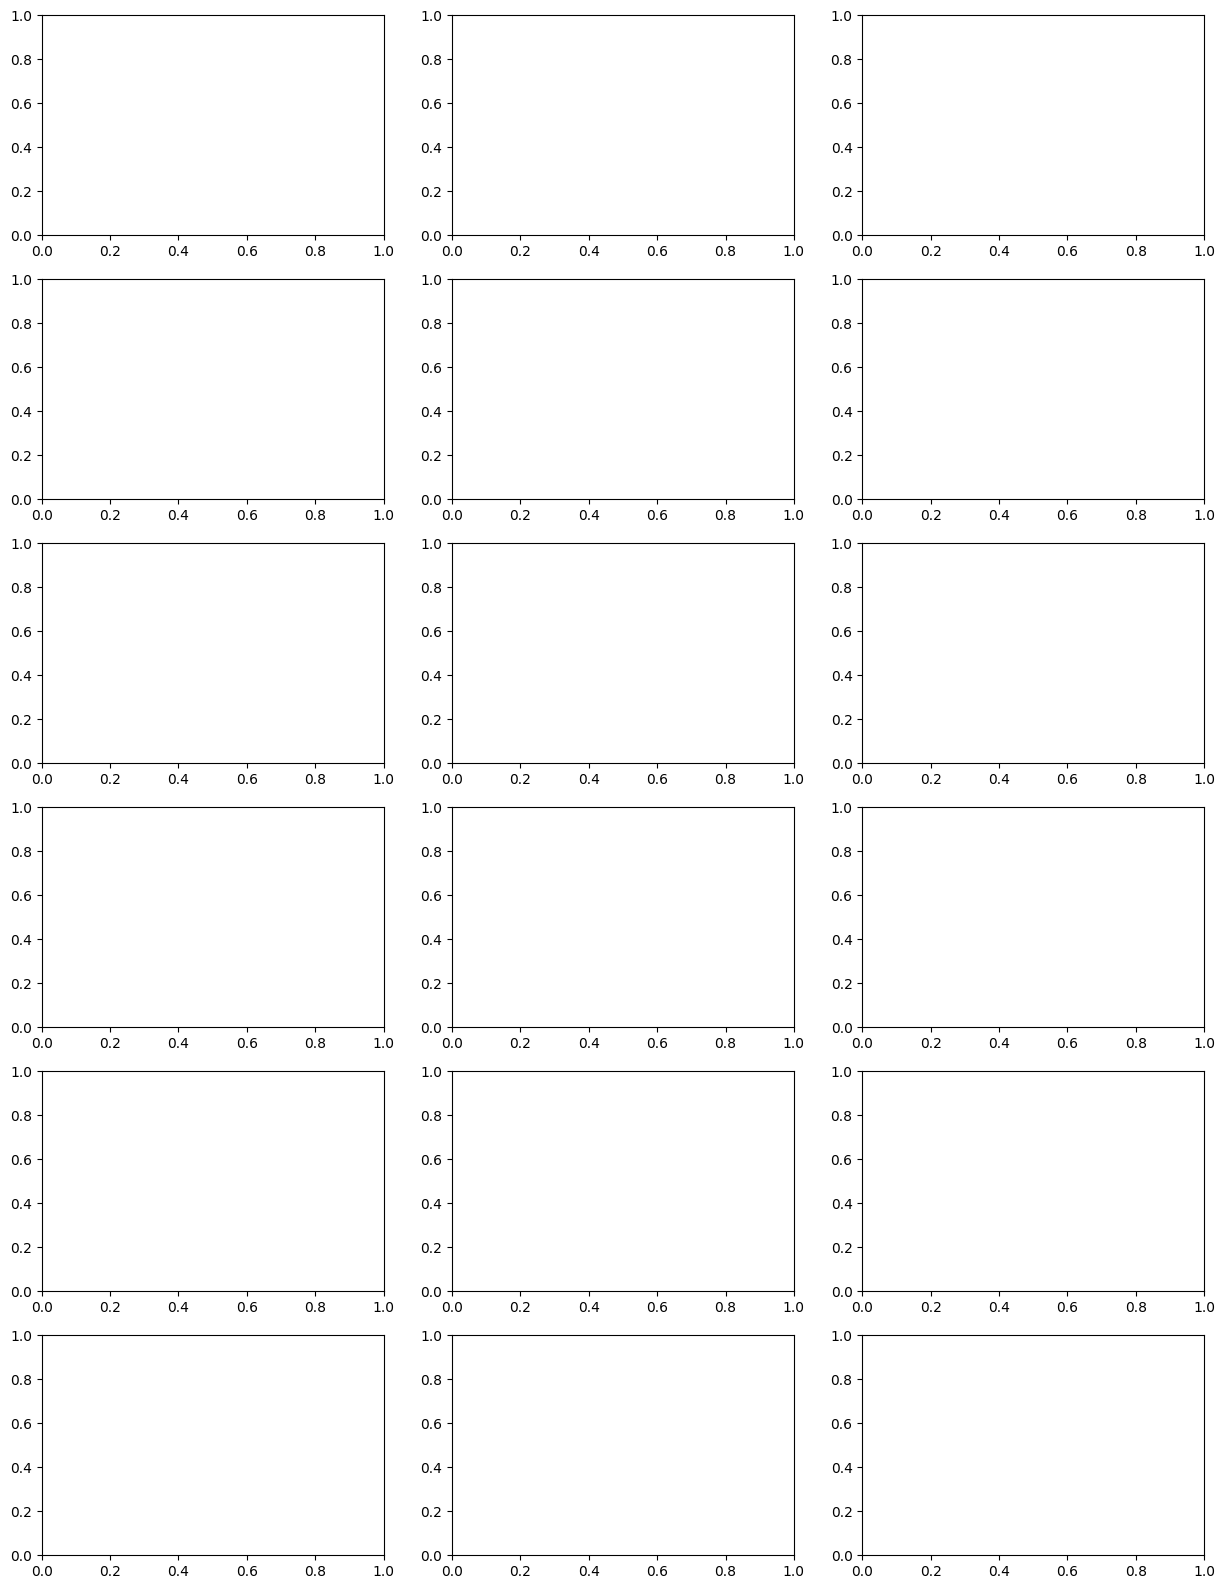

In [38]:
best_image_data = []
fig, axs = plt.subplots(len(rowNames), 3, figsize=(15, 20))
for i, rowName in enumerate(rowNames):
    best_image_data_row = []
    for j, lang in enumerate(["FR", "EN", "NL"]):
        text = rowName[lang]
        recordID = best_images[i][j]
        data = getDataFromRecordID(recordID)
        best_image_data_row.append(data["image_path"])
        title = data["title"]
        artist = data["artist"]
        print(lang, text)
        
    best_image_data.append(best_image_data_row)

#plt.tight_layout()
#plt.show()

In [33]:
import shutil

os.makedirs("temp_images", exist_ok=True)
for row in range(len(rowNames)):
    print("Captions:")
    for langIndex, lang in enumerate(["FR", "EN", "NL"]):
        print(f"    {lang}: {rowNames[row][lang]}", best_image_data[row][langIndex])
        # Copy the image to the temp folder
        image_path = best_image_data[row][langIndex]
        shutil.copy(image_path, f"temp_images/{row}_{lang}.jpg")

Captions:
    FR: Une maison avec un jardin ./../../private_data/local_images/art-foto/mod/Internet/Claus-4006-L.jpg
    EN: A house with a garden ./../../private_data/local_images/art-foto/mod/Internet/DeBraekeleer-4083-L.jpg
    NL: Een huis met een tuin ./../../private_data/local_images/art-foto/old/Internet/Pronk-4060_2916dig-L.jpg
Captions:
    FR: Un homme avec un chapeau ./../../private_data/local_images/art-foto/old/Internet/Dou-4060.1106ZW-L.jpg
    EN: A man with a hat ./../../private_data/local_images/art-foto/old/Internet/Leveck-3557-L.jpg
    NL: Een man met een hoed ./../../private_data/local_images/art-foto/old/Internet/Jordaens-3295dig-L.jpg
Captions:
    FR: Un chien ./../../private_data/local_images/art-foto/mod/Internet/Stevens-3570-L.jpg
    EN: A dog ./../../private_data/local_images/art-foto/old/Internet/vanderWerff-4060_4006-L.jpg
    NL: Een hond ./../../private_data/local_images/art-foto/old/Internet/vanderWerff-4060_4006-L.jpg
Captions:
    FR: Un paysage avec